# Ensemble of different architectures

## Start

In [27]:
#Create references to important directories we will use over and over
import os, sys
from importlib import reload
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
from scipy.optimize import minimize_scalar
import time
import seaborn as sns
import pandas as pd
import keras
from datetime import datetime
#from utils import *
from keras import backend as K
K.set_image_dim_ordering('tf')
%matplotlib inline
sns.set()

from PIL import Image
from keras.preprocessing import image
from keras.layers import Dense, Conv2D, Input, Dropout
from keras.applications import xception, resnet50, inception_resnet_v2, imagenet_utils
from keras.optimizers import SGD, Adam
from keras.utils.np_utils import to_categorical
from tensorboard_callback import TensorBoard

import bcolz
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()

def load_array(fname):
    return bcolz.open(fname)[:]

In [28]:
current_dir = os.getcwd()
DATA_HOME_DIR = current_dir+'/data/dogscats'

path = DATA_HOME_DIR + '/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path = DATA_HOME_DIR + '/results/'
predictions_path = DATA_HOME_DIR + '/results/predictions/'
train_path = path + '/train/'
valid_path = path + '/valid/'
model_path = path + '/models/'

### Different model choices

In [4]:
def model_choice(model_name):
    return { 'Xception':
               (xception.Xception, 
                (299, 299, 3), 
                xception.preprocess_input),
            
             'InceptionResNetV2':
               (inception_resnet_v2.InceptionResNetV2, 
                (299, 299, 3), 
                inception_resnet_v2.preprocess_input),
            
             'ResNet50':
               (resnet50.ResNet50, 
                (299, 299, 3), 
                imagenet_utils.preprocess_input),}.get(model_name)
MODEL, input_shape, preprocess = model_choice('InceptionResNetV2')

## Generate augmented images to bottleneck from

In [3]:
def generate_augmented_images(input_shape=(299, 299, 3), batch_size=20, aug_mult=1):
    train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299

    train_gen = image.ImageDataGenerator(rotation_range=10,
                                         width_shift_range=0.1,
                                         height_shift_range=0.1,
                                         shear_range=0.1,
                                         zoom_range=0.1,
                                         horizontal_flip=True)

    train_batches = train_gen.flow_from_directory(train_path,
                                                  shuffle=False,        ###############
                                                  batch_size=batch_size, 
                                                  class_mode='categorical', 
                                                  target_size=input_shape[:-1])
    
    # create dirs for each class
    %cd $path
    for fn in set(map(os.path.dirname, train_batches.filenames)):
        os.makedirs(f'{train_aug_dir}/{fn}', exist_ok=True)
        
    
    for i in enumerate(tqdm(range(int(train_batches.samples/train_batches.batch_size*aug_mult)))):
        batch = train_batches.next()
        idx = ((train_batches.batch_index - 1)*train_batches.batch_size)%train_batches.samples
        filenames = train_batches.filenames[idx:idx+train_batches.batch_size]

        # TODO:
        assert len(filenames) == len(batch[0]), 'train_batch.samples is not divisible by batch_size'

        for img, filename in zip(batch[0], filenames):
            new_filename = f'{path}/{train_aug_dir}/{filename.split(".jpg")[-2]}.{i[0]}.jpg'
            Image.fromarray(img.swapaxes(1, 2).transpose().astype('uint8')).save(new_filename)

In [4]:
generate_augmented_images(input_shape=input_shape, aug_mult=5)

Found 23000 images belonging to 2 classes.
C:\Python\AI\data\dogscats


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5750/5750 [52:36<00:00,  1.82it/s]


In [ ]:
from keras.applications.xception.

## Generate bottlenecks

In [13]:
def generate_bottlenecks(MODEL=xception.Xception, input_shape=(299, 299, 3), batch_size=20, preprocess=xception.preprocess_input):
    train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299
    # generator will load augmented samples
    gen = image.ImageDataGenerator(preprocessing_function=preprocess)
    train_batches = gen.flow_from_directory(path+train_aug_dir,
                                            shuffle=False,
                                            batch_size=batch_size, 
                                            class_mode='categorical', 
                                            target_size=input_shape[:-1])
    valid_batches = gen.flow_from_directory(valid_path,
                                            shuffle=False,
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                            target_size=input_shape[:-1])
    test_batches = gen.flow_from_directory(test_path,
                                           shuffle=False,
                                           batch_size=batch_size,
                                           class_mode=None,
                                           target_size=input_shape[:-1])

    model = MODEL(include_top=False, 
                  weights='imagenet', 
                  #input_tensor=x, 
                  input_shape=input_shape, 
                  pooling='avg')
    # save conv predictions after avg pooling layer as features
    # train set - images and labels
    train_features = model.predict_generator(train_batches, train_batches.n/train_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_train_features.bc', train_features)
    save_array(f'{model_path}/{MODEL.__name__}_train_labels.bc', to_categorical(train_batches.classes))
    
    # validation set - images, labels and filenames
    valid_features = model.predict_generator(valid_batches, valid_batches.n/valid_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_valid_features.bc', valid_features)
    save_array(f'{model_path}/{MODEL.__name__}_valid_labels.bc', to_categorical(valid_batches.classes))
    save_array(f'{model_path}/{MODEL.__name__}_valid_filenames.bc', valid_batches.filenames)
    
    # test set - images and filenames(ids)
    test_features = model.predict_generator(test_batches, test_batches.n/test_batches.batch_size, verbose=1)
    save_array(f'{model_path}/{MODEL.__name__}_test_features.bc', test_features)
    save_array(f'{model_path}/{MODEL.__name__}_test_filenames.bc', list(map(lambda filename: 
                                                                               int(filename[8:].split('.jpg')[-2]), 
                                                                            test_batches.filenames)))
    
generate_bottlenecks(MODEL=MODEL, input_shape=input_shape, batch_size=20, preprocess=preprocess)

Found 138000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
625/625 [==============================] - 420s   


#### Dirty hack for now

In [ ]:
#MODEL=xception.Xception
#input_shape=(299, 299, 3)
batch_size=20
#preprocess=xception.preprocess_input

train_aug_dir = 'train_aug_'+'x'.join(map(str, input_shape))  # train_aug_3x299x299
# generator will load augmented samples
gen = image.ImageDataGenerator(preprocessing_function=preprocess)
train_batches = gen.flow_from_directory(path+train_aug_dir,
                                        shuffle=False,
                                        batch_size=batch_size, 
                                        class_mode='categorical', 
                                        target_size=input_shape[:-1])

# preprocess input
#x = keras.layers.Input(input_shape)
#if preprocess:
#    x = keras.layers.Lambda(preprocess, input_shape=input_shape)(x)

model = MODEL(include_top=False, 
              weights='imagenet', 
              #input_tensor=x, 
              input_shape=input_shape, 
              pooling='avg')
# save conv predictions after avg pooling layer as features
# validation set - images, labels and filenames
train_features = model.predict_generator(train_batches, 10, verbose=1)
#save_array(f'{model_path}/{MODEL.__name__}_valid_features123.bc', valid_features)
#save_array(f'{model_path}/{MODEL.__name__}_valid_labels123.bc', valid_batches.classes)
#save_array(f'{model_path}/{MODEL.__name__}_valid_filenames123.bc', valid_batches.filenames)

# model = keras.models.Sequential()
# dropout_p = 0.5

# model.add(Dense(2048, input_shape=(2048,), activation='relu'))
# model.add(Dropout(dropout_p))
# model.add(Dense(2048, activation='relu'))
# model.add(Dropout(dropout_p))
# model.add(Dense(2, activation='softmax'))

# model.compile(Adam(lr=0.002), 'categorical_crossentropy', metrics=['acc'])
# model.fit(train_features, train_batches.classes[:200], batch_size=10, epochs=1)

## Make a new model

In [29]:
def get_features(MODEL=xception.Xception):
    train_features = load_array(f'{model_path}/{MODEL.__name__}_train_features.bc')
    train_labels = load_array(f'{model_path}/{MODEL.__name__}_train_labels.bc')
    valid_features = load_array(f'{model_path}/{MODEL.__name__}_valid_features.bc')
    valid_labels = load_array(f'{model_path}/valid_labels.bc')
    valid_filenames = load_array(f'{model_path}/valid_filenames.bc')
    test_features = load_array(f'{model_path}/{MODEL.__name__}_test_features.bc')
    test_filenames = load_array(f'{model_path}/test_filenames.bc')
    return (train_features, train_labels, 
           valid_features, valid_labels, valid_filenames, 
           test_features, test_filenames)

(train_features, train_labels, 
 valid_features, valid_labels, valid_filenames, 
 test_features, test_filenames) = get_features(MODEL)

In [5]:
Resnet = keras.applications.InceptionResNetV2(include_top=True, weights='imagenet', input_shape=(299, 299, 3), pooling='avg')
Resnet.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

conv2d_353 (Conv2D)             (None, 17, 17, 128)  139264      block17_18_ac[0][0]              
__________________________________________________________________________________________________
batch_normalization_353 (BatchN (None, 17, 17, 128)  384         conv2d_353[0][0]                 
__________________________________________________________________________________________________
activation_353 (Activation)     (None, 17, 17, 128)  0           batch_normalization_353[0][0]    
__________________________________________________________________________________________________
conv2d_354 (Conv2D)             (None, 17, 17, 160)  143360      activation_353[0][0]             
__________________________________________________________________________________________________
batch_normalization_354 (BatchN (None, 17, 17, 160)  480         conv2d_354[0][0]                 
__________________________________________________________________________________________________
activation

In [30]:
class Top_Layer:
    def __init__(self, dropout_p = 0.5, batch_size = 10000):
        self.batch_size = batch_size
        self.model = keras.models.Sequential()
        self.model.add(Dense(2048, input_shape=(2048,), activation='relu'))
        self.model.add(Dropout(dropout_p))
        self.model.add(Dense(2048, activation='relu'))
        self.model.add(Dropout(dropout_p))
        self.model.add(Dense(2, activation='softmax'))
        
        self.model.compile(SGD(lr=0.01), 'categorical_crossentropy', metrics=['acc'])
        #self.model.compile(Adam(lr=0.001), 'categorical_crossentropy', metrics=['acc'])
        
        log_dir = path + 'logs/' + datetime.now().strftime('%Y%m%d-%H%M%S') + '/'
        self.tb_cb = TensorBoard(log_dir=log_dir, batch_size=self.batch_size, write_batch_performance=True)
    
    def fit(self, train_features, train_labels, valid_features, valid_labels, *args, **kwargs):
        return self.model.fit(train_features, 
                              train_labels, 
                              batch_size=self.batch_size, 
                              epochs=1, 
                              validation_data=(valid_features, valid_labels), 
                              callbacks=[self.tb_cb], 
                              **kwargs).history
    
    def predict(self, test_features, *args, **kwargs):
        return self.model.predict(test_features, batch_size=self.batch_size, **kwargs)

xcep = Top_Layer(dropout_p=0.8, batch_size=10000)
epoch = 0

## Training a new model

In [50]:
xcep.model.compile(SGD(lr=0.05), 'categorical_crossentropy', metrics=['acc'])

In [49]:
no_of_epochs = 10
model_name = f'{MODEL.__name__}_bnda6_sgd'
for next_epoch in range(no_of_epochs):
    print(f'Running epoch: {epoch}')
    hist = xcep.fit(train_features, train_labels, valid_features, valid_labels)
    latest_weights_filename = f"{model_name}_v{(hist['val_loss'][0]):.4}_{epoch}.h5"
    xcep.model.save_weights(results_path+latest_weights_filename)
    epoch += 1
print(f'Completed {no_of_epochs} fit operations')

Running epoch: 64
Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0333 - acc: 0.9896 - val_loss: 0.0139 - val_acc: 0.9970
Running epoch: 65
Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0313 - acc: 0.9905 - val_loss: 0.0138 - val_acc: 0.9970
Running epoch: 66
Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0323 - acc: 0.9902 - val_loss: 0.0137 - val_acc: 0.9970
Running epoch: 67
Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0310 - acc: 0.9903 - val_loss: 0.0138 - val_acc: 0.9970
Running epoch: 68
Train on 138000 samples, validate on 2000 samples
Epoch 1/1
138000/138000 [==============================] - 5s - loss: 0.0323 - acc: 0.9901 - val_loss: 0.0136 - val_acc: 0.9970
Running epoch: 69
Tr

In [58]:
model.save_weights(results_path+'resnet_bnda6_v0.0254_8.h5')

In [61]:
model.load_weights(results_path+'resnet_bnda6_v0.0254_8.h5')

## Predictions

### Single model predictions

In [51]:
test_preds = xcep.model.predict(test_features, batch_size=10000)
valid_preds = xcep.model.predict(valid_features, batch_size=10000)
isdog = test_preds[:, 1]
val_isdog = valid_preds[:, 1]

### Ensemble predictions

In [31]:
from glob import glob
test_preds = []
valid_preds = []
model_files = ['Xception_bnda6_v0.0184_5.h5', 'ResNet50_bnda6_v0.0254_8.h5', 'Xception_bnda6_sgd_v0.01367_73.h5', 'Xception_bnda6_sgd_v0.01391_58.h5']
#model_files = glob(results_path+'*bnda6*')
for model_file in sorted(model_files, key=lambda x: x.split('_')[0]):  # group by architecture
    print(f'Loading {model_file} ...')
    next_architecture = model_file.split('_')[0]
    if MODEL.__name__ != next_architecture:
        MODEL, input_shape, preprocess = model_choice(next_architecture)  # get architecture from filename
        (train_features, train_labels, 
         valid_features, valid_labels, valid_filenames, 
         test_features, test_filenames) = get_features(MODEL)
    
    xcep.model.load_weights(results_path+model_file)
    test_preds.append(xcep.model.predict(test_features, batch_size=10000)[:, 1])
    valid_preds.append(xcep.model.predict(valid_features, batch_size=10000)[:, 1])
    
val_isdog = np.stack(valid_preds).mean(axis=0)
isdog = np.stack(test_preds).mean(axis=0)

Loading ResNet50_bnda6_v0.0254_8.h5 ...
Loading Xception_bnda6_v0.0184_5.h5 ...
Loading Xception_bnda6_sgd_v0.01367_73.h5 ...
Loading Xception_bnda6_sgd_v0.01391_58.h5 ...


In [33]:
#import scipy
#val_isdog = scipy.stats.mstats.gmean(np.stack(valid_preds), axis=0)
#isdog = scipy.stats.mstats.gmean(np.stack(test_preds), axis=0)

### Visualization

In [44]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    import itertools
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(len(classes))
    tick_marks = []
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[996   4]
 [  2 998]]


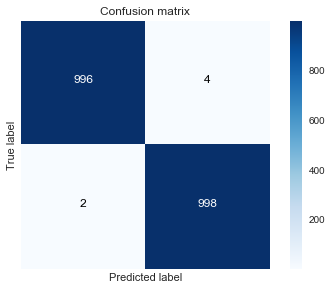

In [45]:
val_predicted_labels = np.round(val_isdog)
val_expected_labels = valid_labels[:, 1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(val_expected_labels, val_predicted_labels)
plot_confusion_matrix(cm, ['cat', 'dog'])

In [46]:
from keras.preprocessing import image
from numpy.random import permutation
#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots(ims, figsize=(24,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + valid_filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 8

Found 6 incorrect labels


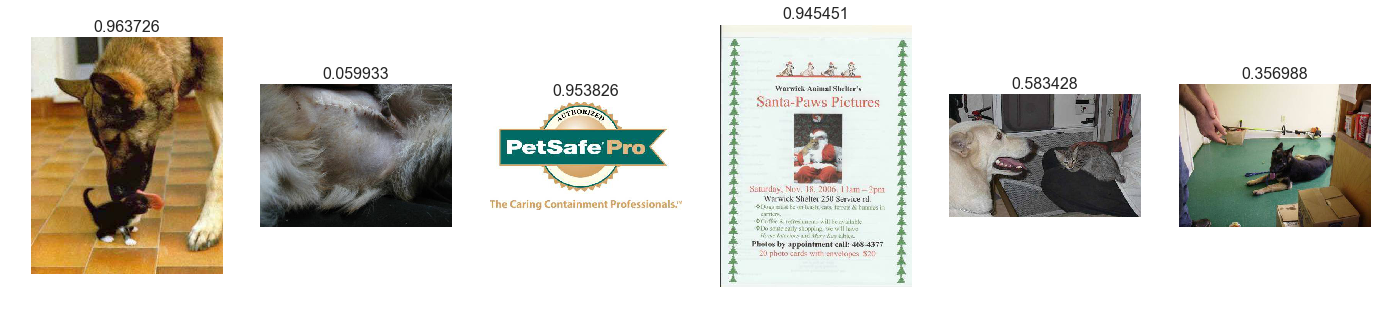

In [47]:
#2. A few incorrect labels at random
incorrect = np.where(val_expected_labels!=val_predicted_labels)[0]
print(f"Found {len(incorrect)} incorrect labels")
idx = permutation(incorrect)[:n_view]
plots_idx(idx, val_isdog[idx])

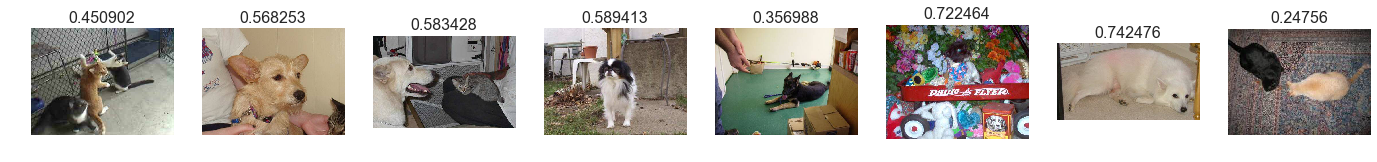

In [48]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(val_isdog-0.5))
plots_idx(most_uncertain[:n_view], val_isdog[most_uncertain])

In [49]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, roc_curve
print('precision:', precision_score(val_expected_labels, val_predicted_labels)) 
print('recall:', recall_score(val_expected_labels, val_predicted_labels)) 
print('accuracy:', accuracy_score(val_expected_labels, val_predicted_labels))

precision: 0.996007984032
recall: 0.998
accuracy: 0.997


## Submission

In [50]:
import scipy
min_logloss = scipy.optimize.minimize_scalar(lambda x: log_loss(val_expected_labels, val_isdog, eps=x), bounds=(1e-10, 0.1), method='bounded')
min_logloss

     fun: 0.013212240206406477
 message: 'Solution found.'
    nfev: 20
  status: 0
 success: True
       x: 6.6107961285789138e-06

In [59]:
min_logloss_f

0.017246396864997224

In [58]:
eps = np.clip(min_logloss.x, 0.005, 0.05)
min_logloss_f = log_loss(val_expected_labels, val_isdog, eps=eps)
isdog = isdog.clip(min=eps, max=1-eps)

In [60]:
subm = np.stack([test_filenames, isdog], axis=1)
%cd $DATA_HOME_DIR
submission_file_name = 'submission16.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')
pd.read_csv(submission_file_name, index_col='id')

C:\Python\AI\data\dogscats


,label
id,
1,0.99500
10,0.00500
100,0.00500
1000,0.99500
10000,0.99500
10001,0.00500
10002,0.00500
10003,0.99500
10004,0.99500


In [61]:
submission_message = f"Xception+ResNet50 299x299 with BN and DAx6 bottlenecks ensemble[4] -- {model_files} logloss={min_logloss_f:.5} eps={eps:.5}"
!kg submit $submission_file_name -m "$submission_message"

0.03893


In [61]:
submission_message = f"Xception 299x299 with BN and DAx6 bottlenecks -- {latest_weights_filename} logloss={min_logloss_f:.5} eps={eps:.5}"
!kg submit $submission_file_name -m "$submission_message"

0.04135
